In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import StrMethodFormatter

import os
from os import path
from glob import glob
import sys
import csv
sys.path.insert(0, path.abspath('./'))

from src import workdir, parse_model_parameter_file
from src.emulator_BAND import EmulatorBAND
#from src.emulator import Emulator

import re

#parent="../actual/"
parent="/home/niklas/Desktop/lustre/good_bayes/inference/actual/"


In [10]:
def rms_abs_prediction_err(emu_pred,vali_true):
    rms_abs_pred_err = np.zeros(emu_pred.shape[1])
    for obsIdx in range(emu_pred.shape[1]):
        quantity = np.zeros(emu_pred.shape[1])
        for testpoint in range(emu_pred.shape[0]):
            quantity[obsIdx] += ((emu_pred[testpoint,obsIdx] - vali_true[testpoint,obsIdx]) / vali_true[testpoint,obsIdx])**2.
        rms_abs_pred_err[obsIdx] = np.sqrt(quantity[obsIdx] / emu_pred.shape[0])
    return rms_abs_pred_err

def how_honest_is_GP(emu_pred,emu_pred_err,vali_true):
    rms_quantity = np.zeros(emu_pred.shape[1])
    for obsIdx in range(emu_pred.shape[1]):
        quantity = np.zeros(emu_pred.shape[1])
        for testpoint in range(emu_pred.shape[0]):
            quantity[obsIdx] += ((emu_pred[testpoint,obsIdx] - vali_true[testpoint,obsIdx]) / emu_pred_err[testpoint,obsIdx])**2.
        rms_quantity[obsIdx] = np.sqrt(quantity[obsIdx] / emu_pred.shape[0])
    return rms_quantity

def train_multiple_emulators(training_set, model_par, number_test_points, logFlag, parameterTrafoPCAFlag):
    emu1 = EmulatorBAND(training_set, model_par, method='PCGP', logTrafo=logFlag, parameterTrafoPCA=parameterTrafoPCAFlag)
    emu2 = EmulatorBAND(training_set, model_par, method='PCSK', logTrafo=logFlag, parameterTrafoPCA=parameterTrafoPCAFlag)
    #emu3 = Emulator(training_set, model_par, npc = 4, logTrafo=logFlag, parameterTrafoPCA=parameterTrafoPCAFlag)

    output_emu1 = emu1.testEmulatorErrors(number_test_points=number_test_points)
    emu_pred_1 = output_emu1[0]
    emu_pred_err_1 = output_emu1[1]
    vali_data_1 = output_emu1[2]
    vali_data_err_1 = output_emu1[3]

    output_emu2 = emu2.testEmulatorErrors(number_test_points=number_test_points)
    emu_pred_2 = output_emu2[0]
    emu_pred_err_2 = output_emu2[1]
    vali_data_2 = output_emu2[2]
    vali_data_err_2 = output_emu2[3]

    # output_emu3 = emu3.testEmulatorErrors(nTestPoints=number_test_points)
    # emu_pred_3 = output_emu3[0]
    # emu_pred_err_3 = output_emu3[1]
    # vali_data_3 = output_emu3[2]
    # vali_data_err_3 = output_emu3[3]

    nObs = vali_data_1.shape[1]  # Assuming all datasets have the same number of observables

    rms_abs_pred_err1 = rms_abs_prediction_err(emu_pred_1,vali_data_1)
    rms_abs_pred_err2 = rms_abs_prediction_err(emu_pred_2,vali_data_2)
    #rms_abs_pred_err3 = rms_abs_prediction_err(emu_pred_3,vali_data_3)
    honesty_1 = how_honest_is_GP(emu_pred_1,emu_pred_err_1,vali_data_1)
    honesty_2 = how_honest_is_GP(emu_pred_2,emu_pred_err_2,vali_data_2)
    #honesty_3 = how_honest_is_GP(emu_pred_3,emu_pred_err_3,vali_data_3)

    return (rms_abs_pred_err1,rms_abs_pred_err2), (honesty_1,honesty_2)


In [11]:
def read_emulator_file_errors(filename):
    data = []
    print(filename)
    with open(filename, 'r') as file:
        for line in file:
            if not line.startswith("Average"):
                data.append(float(line.strip()))
    return data

def read_multiple_emulator_errors_files(number_test_points_list,foldername,filename):
    data_list1 = []
    data_list2 = []

    for i in number_test_points_list:
        filename1 = f"{foldername}/{filename}_{i}_pred_err_obs_PCGP_nolog_nopca.dat"
        data1 = read_emulator_file_errors(filename1)
        data_list1.append(data1)

        filename2 = f"{foldername}/{filename}_{i}_pred_err_obs_PCSK_nolog_nopca.dat"
        data2 = read_emulator_file_errors(filename2)
        data_list2.append(data2)

        # filename3 = f"./{foldername}/{filename}_{i}_pred_err_obs_3.dat"
        # data3 = read_emulator_file_errors(filename3)
        # data_list3.append(data3)
    
    data_list4 = []
    data_list5 = []

    for i in number_test_points_list:
        filename4 = f"{foldername}/{filename}_{i}_GP_honesty_obs_PCGP_nolog_nopca.dat"
        data4 = read_emulator_file_errors(filename4)
        data_list4.append(data4)

        filename5 = f"{foldername}/{filename}_{i}_GP_honesty_obs_PCSK_nolog_nopca.dat"
        data5 = read_emulator_file_errors(filename5)
        data_list5.append(data5)

    data_list6 = []
    data_list7 = []

    for i in number_test_points_list:
        filename6 = f"{foldername}/{filename}_{i}_GP_bias_obs_PCGP_nolog_nopca.dat"
        data6 = read_emulator_file_errors(filename6)
        data_list6.append(data6)

        filename7 = f"{foldername}/{filename}_{i}_GP_bias_obs_PCSK_nolog_nopca.dat"
        data7 = read_emulator_file_errors(filename7)
        data_list7.append(data7)

    return (data_list1,data_list2), (data_list4,data_list5), (data_list6,data_list7)


In [12]:


def convert_to_notation(filename):
    # Remove 'exp_', '../latent_pickled/', and '.pkl'
    filename = re.sub(r'(exp_|\.pkl|../latent_pickled/)', '', filename)
    filename = re.sub(r'star_v(.*)_pT', r'starv\1pt', filename)
    filename = re.sub(r'star_v', 'starv', filename)
    filename = re.sub(r'phenix_pT_v', 'phenixptv', filename)
    filename = re.sub(r'stareta_spectra', 'etas', filename)
    filename = re.sub(r'eta_spectra', 'etas', filename)
    
    filename = re.sub(r'y_spectra', 'ys', filename)
    filename = re.sub(r'pT_spectra', 'pTs', filename)
    filename = re.sub(r'phobos_v2_spectra', 'v2eta', filename)
    # Mapping for observables
    observables = {
        'etas': r'$\frac{dN}{d\eta}$',
        'ys': r'$\frac{dN}{dy}$',
        'pTs': r'$\frac{dN}{d(p_T)}$',
        'dNdy': r'$\left.\frac{dN}{dy}\right|_{y=0}$',
        'meanpT': r'$\langle p_T \rangle |_{y=0}$',
        'starv2': r'$\left.v_2\right.\{2\}$',
        'starv3': r'$\left.v_3\right.\{2\}$',
        'phenixptv2': r'$v_2(p_T)$',
        'phenixptv3': r'$v_3(p_T)$',
        'starv2pt': r'$v_2(p_T)$',
        'starv3pt': r'$v_3(p_T)$',
        'v2eta': r'$v_2(\eta)$'
    }
    particles= {
        'kminus': r'K^-',
        'kplus': r'K^+',
        'p': 'p',
        'pbar': r'\bar{p}',
        'piminus': r'\pi^-',
        'piplus': r'\pi^+'
    }   
    
    # Identify the particle and the observable
    #print(filename)
   
    parts = filename.split('_')
    print(parts)
    #print(parts)
    particle = ''
    observable = ''
    integrated = False
    for part in parts:
        if part in observables:
            observable = observables[part]
        elif part in particles:
            particle = particles[part]
        elif part == 'integrated':
            integrated = True
    # Add particle notation for y_spectra
    #print(particle)
    if integrated and particle == '\pi^-':
        pass
    elif integrated and particle != '':
        observable=''
    elif ('ys' in filename or 'pTs' in filename or integrated) and not ('star' in filename and not 'stareta' in filename):
        observable = observable[:-1] + f'({particle})$'

   
    #print(observable)
    #print("------")
    # Return the formatted string
    return observable

print(convert_to_notation('star_v2_pT_spectra.pkl'))
print(convert_to_notation('star_v2_pT_spectra'))
print(convert_to_notation('eta_spectra'))
print(convert_to_notation('stareta_spectra'))

['starv2pt', 'spectra']
$v_2(p_T)$
['starv2pt', 'spectra']
$v_2(p_T)$
['etas']
$\frac{dN}{d\eta}$
['etas']
$\frac{dN}{d\eta}$


In [13]:
import pickle

def extract_info_from_filename(filename):
    # Remove the path and extension
    parts = filename.split('_')
    
    # Extract energy, centrality, and observable
    energy = parts[1]
    centrality = parts[2]
    observable = '_'.join(parts[3:])


    
    return energy, centrality, observable

import re

filename_prefix_list = []
#training_set= ['../latent_pickled/exp_19.6_05_eta_spectra.pkl', '../latent_pickled/exp_200_05_y_spectra_piminus.pkl', '../latent_pickled/exp_19.6_05_integrated_dNdy_kminus.pkl', '../latent_pickled/exp_19.6_05_integrated_dNdy_kplus.pkl', '../latent_pickled/exp_19.6_05_integrated_dNdy_p.pkl', '../latent_pickled/exp_19.6_05_integrated_dNdy_pbar.pkl', '../latent_pickled/exp_19.6_05_integrated_dNdy_piminus.pkl', '../latent_pickled/exp_19.6_05_integrated_dNdy_piplus.pkl', '../latent_pickled/exp_19.6_05_integrated_meanpT_kminus.pkl', '../latent_pickled/exp_19.6_05_integrated_meanpT_kplus.pkl', '../latent_pickled/exp_19.6_05_integrated_meanpT_p.pkl', '../latent_pickled/exp_19.6_05_integrated_meanpT_pbar.pkl', '../latent_pickled/exp_19.6_05_integrated_meanpT_piminus.pkl', '../latent_pickled/exp_19.6_05_integrated_meanpT_piplus.pkl', '../latent_pickled/exp_19.6_05_integrated_star_v2.pkl', '../latent_pickled/exp_19.6_05_integrated_star_v3.pkl', '../latent_pickled/exp_200_05_y_spectra_piplus.pkl', '../latent_pickled/exp_19.6_05_pT_spectra_kminus.pkl', '../latent_pickled/exp_200_1525_eta_spectra.pkl', '../latent_pickled/exp_19.6_05_pT_spectra_kplus.pkl', '../latent_pickled/exp_200_1525_phobos_v2_spectra.pkl', '../latent_pickled/exp_19.6_05_pT_spectra_p.pkl', '../latent_pickled/exp_200_2030_integrated_dNdy_kminus.pkl', '../latent_pickled/exp_200_2030_integrated_dNdy_kplus.pkl', '../latent_pickled/exp_200_2030_integrated_dNdy_p.pkl', '../latent_pickled/exp_200_2030_integrated_dNdy_pbar.pkl', '../latent_pickled/exp_200_2030_integrated_dNdy_piminus.pkl', '../latent_pickled/exp_200_2030_integrated_dNdy_piplus.pkl', '../latent_pickled/exp_200_2030_integrated_meanpT_kminus.pkl', '../latent_pickled/exp_200_2030_integrated_meanpT_kplus.pkl', '../latent_pickled/exp_200_2030_integrated_meanpT_p.pkl', '../latent_pickled/exp_200_2030_integrated_meanpT_pbar.pkl', '../latent_pickled/exp_200_2030_integrated_meanpT_piminus.pkl', '../latent_pickled/exp_200_2030_integrated_meanpT_piplus.pkl', '../latent_pickled/exp_200_2030_integrated_star_v2.pkl', '../latent_pickled/exp_200_2030_integrated_star_v3.pkl', '../latent_pickled/exp_19.6_05_pT_spectra_pbar.pkl', '../latent_pickled/exp_200_2030_phenix_pT_v2_spectra.pkl', '../latent_pickled/exp_19.6_05_pT_spectra_piminus.pkl', '../latent_pickled/exp_200_2030_phenix_pT_v3_spectra.pkl', '../latent_pickled/exp_19.6_05_pT_spectra_piplus.pkl', '../latent_pickled/exp_200_2030_pT_spectra_kminus.pkl', '../latent_pickled/exp_19.6_1525_eta_spectra.pkl', '../latent_pickled/exp_200_2030_pT_spectra_kplus.pkl', '../latent_pickled/exp_200_2030_pT_spectra_p.pkl', '../latent_pickled/exp_19.6_2030_integrated_dNdy_kminus.pkl', '../latent_pickled/exp_19.6_2030_integrated_dNdy_kplus.pkl', '../latent_pickled/exp_19.6_2030_integrated_dNdy_p.pkl', '../latent_pickled/exp_19.6_2030_integrated_dNdy_pbar.pkl', '../latent_pickled/exp_19.6_2030_integrated_dNdy_piminus.pkl', '../latent_pickled/exp_19.6_2030_integrated_dNdy_piplus.pkl', '../latent_pickled/exp_19.6_2030_integrated_meanpT_kminus.pkl', '../latent_pickled/exp_19.6_2030_integrated_meanpT_kplus.pkl', '../latent_pickled/exp_19.6_2030_integrated_meanpT_p.pkl', '../latent_pickled/exp_19.6_2030_integrated_meanpT_pbar.pkl', '../latent_pickled/exp_19.6_2030_integrated_meanpT_piminus.pkl', '../latent_pickled/exp_19.6_2030_integrated_meanpT_piplus.pkl', '../latent_pickled/exp_19.6_2030_integrated_star_v2.pkl', '../latent_pickled/exp_19.6_2030_integrated_star_v3.pkl', '../latent_pickled/exp_200_2030_pT_spectra_pbar.pkl', '../latent_pickled/exp_19.6_2030_pT_spectra_kminus.pkl', '../latent_pickled/exp_200_2030_pT_spectra_piminus.pkl', '../latent_pickled/exp_19.6_2030_pT_spectra_kplus.pkl', '../latent_pickled/exp_200_2030_pT_spectra_piplus.pkl', '../latent_pickled/exp_19.6_2030_pT_spectra_p.pkl', '../latent_pickled/exp_7.7_05_integrated_dNdy_kminus.pkl', '../latent_pickled/exp_7.7_05_integrated_dNdy_kplus.pkl', '../latent_pickled/exp_7.7_05_integrated_dNdy_p.pkl', '../latent_pickled/exp_7.7_05_integrated_dNdy_pbar.pkl', '../latent_pickled/exp_7.7_05_integrated_dNdy_piminus.pkl', '../latent_pickled/exp_7.7_05_integrated_dNdy_piplus.pkl', '../latent_pickled/exp_7.7_05_integrated_meanpT_kminus.pkl', '../latent_pickled/exp_7.7_05_integrated_meanpT_kplus.pkl', '../latent_pickled/exp_7.7_05_integrated_meanpT_p.pkl', '../latent_pickled/exp_7.7_05_integrated_meanpT_pbar.pkl', '../latent_pickled/exp_7.7_05_integrated_meanpT_piminus.pkl', '../latent_pickled/exp_7.7_05_integrated_meanpT_piplus.pkl', '../latent_pickled/exp_7.7_05_integrated_star_v2.pkl', '../latent_pickled/exp_7.7_05_integrated_star_v3.pkl', '../latent_pickled/exp_19.6_2030_pT_spectra_pbar.pkl', '../latent_pickled/exp_7.7_05_pT_spectra_kminus.pkl', '../latent_pickled/exp_19.6_2030_pT_spectra_piminus.pkl', '../latent_pickled/exp_7.7_05_pT_spectra_kplus.pkl', '../latent_pickled/exp_19.6_2030_pT_spectra_piplus.pkl', '../latent_pickled/exp_7.7_05_pT_spectra_p.pkl', '../latent_pickled/exp_19.6_2030_star_v2_pT_spectra.pkl', '../latent_pickled/exp_7.7_05_pT_spectra_pbar.pkl', '../latent_pickled/exp_200_05_eta_spectra.pkl', '../latent_pickled/exp_7.7_05_pT_spectra_piminus.pkl', '../latent_pickled/exp_200_05_integrated_dNdy_kminus.pkl', '../latent_pickled/exp_200_05_integrated_dNdy_kplus.pkl', '../latent_pickled/exp_200_05_integrated_dNdy_p.pkl', '../latent_pickled/exp_200_05_integrated_dNdy_pbar.pkl', '../latent_pickled/exp_200_05_integrated_dNdy_piminus.pkl', '../latent_pickled/exp_200_05_integrated_dNdy_piplus.pkl', '../latent_pickled/exp_200_05_integrated_meanpT_kminus.pkl', '../latent_pickled/exp_200_05_integrated_meanpT_kplus.pkl', '../latent_pickled/exp_200_05_integrated_meanpT_p.pkl', '../latent_pickled/exp_200_05_integrated_meanpT_pbar.pkl', '../latent_pickled/exp_200_05_integrated_meanpT_piminus.pkl', '../latent_pickled/exp_200_05_integrated_meanpT_piplus.pkl', '../latent_pickled/exp_200_05_integrated_star_v2.pkl', '../latent_pickled/exp_200_05_integrated_star_v3.pkl', '../latent_pickled/exp_7.7_05_pT_spectra_piplus.pkl', '../latent_pickled/exp_200_05_pT_spectra_kminus.pkl', '../latent_pickled/exp_7.7_2030_integrated_dNdy_kminus.pkl', '../latent_pickled/exp_7.7_2030_integrated_dNdy_kplus.pkl', '../latent_pickled/exp_7.7_2030_integrated_dNdy_p.pkl', '../latent_pickled/exp_7.7_2030_integrated_dNdy_pbar.pkl', '../latent_pickled/exp_7.7_2030_integrated_dNdy_piminus.pkl', '../latent_pickled/exp_7.7_2030_integrated_dNdy_piplus.pkl', '../latent_pickled/exp_7.7_2030_integrated_meanpT_kminus.pkl', '../latent_pickled/exp_7.7_2030_integrated_meanpT_kplus.pkl', '../latent_pickled/exp_7.7_2030_integrated_meanpT_p.pkl', '../latent_pickled/exp_7.7_2030_integrated_meanpT_pbar.pkl', '../latent_pickled/exp_7.7_2030_integrated_meanpT_piminus.pkl', '../latent_pickled/exp_7.7_2030_integrated_meanpT_piplus.pkl', '../latent_pickled/exp_7.7_2030_integrated_star_v2.pkl', '../latent_pickled/exp_7.7_2030_integrated_star_v3.pkl', '../latent_pickled/exp_200_05_pT_spectra_kplus.pkl', '../latent_pickled/exp_7.7_2030_pT_spectra_kminus.pkl', '../latent_pickled/exp_200_05_pT_spectra_p.pkl', '../latent_pickled/exp_7.7_2030_pT_spectra_kplus.pkl', '../latent_pickled/exp_200_05_pT_spectra_pbar.pkl', '../latent_pickled/exp_7.7_2030_pT_spectra_p.pkl', '../latent_pickled/exp_200_05_pT_spectra_piminus.pkl', '../latent_pickled/exp_7.7_2030_pT_spectra_pbar.pkl', '../latent_pickled/exp_200_05_pT_spectra_piplus.pkl', '../latent_pickled/exp_7.7_2030_pT_spectra_piminus.pkl', '../latent_pickled/exp_200_05_y_spectra_kminus.pkl', '../latent_pickled/exp_7.7_2030_pT_spectra_piplus.pkl', '../latent_pickled/exp_200_05_y_spectra_kplus.pkl', '../latent_pickled/exp_7.7_2030_star_v2_pT_spectra.pkl']

from collections import defaultdict

# Initialize the data structure
data = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

foldername = parent+'validation_no_pca'

err1_list = []
err2_list = []
hon1_list = []
hon2_list = []

err, hon, bias  = read_multiple_emulator_errors_files([15], foldername, "data:allenergies:allsystems:base-star-eta:3.0:nostarptcut")
with open(parent+"latent_train_full/data:allenergies:allsystems:base-star-eta:3.0:nostarptcut.pkl", "rb") as fp:
            dataDict = pickle.load(fp)[0] #we only take first event
for i, name in enumerate(dataDict["name"]):
        #filename_prefix_list.append(name)
        if "tau" in name:
            continue
        energy, centrality, observable = extract_info_from_filename(name)
        #print(energy, centrality, observable)
        start=dataDict["lim"][i]
        #print(start)
        end=dataDict["lim"][i+1]
        data[energy][centrality]["name"].append(observable)
        data[energy][centrality]["err1"].append(err[0][0][start:end])
        #print(err1_list[-1][-1])
        data[energy][centrality]["err2"].append(err[1][0][start:end])
        data[energy][centrality]["hon1"].append(hon[0][0][start:end])
        data[energy][centrality]["hon2"].append(hon[1][0][start:end])
        data[energy][centrality]["bias1"].append(bias[0][0][start:end])
        data[energy][centrality]["bias2"].append(bias[1][0][start:end])
print(data[energy][centrality]["bias1"])
print(data[energy][centrality]["bias2"])
print(energy, centrality, observable)        

/home/niklas/Desktop/lustre/good_bayes/inference/actual/validation_no_pca/data:allenergies:allsystems:base-star-eta:3.0:nostarptcut_15_pred_err_obs_PCGP_nolog_nopca.dat
/home/niklas/Desktop/lustre/good_bayes/inference/actual/validation_no_pca/data:allenergies:allsystems:base-star-eta:3.0:nostarptcut_15_pred_err_obs_PCSK_nolog_nopca.dat
/home/niklas/Desktop/lustre/good_bayes/inference/actual/validation_no_pca/data:allenergies:allsystems:base-star-eta:3.0:nostarptcut_15_GP_honesty_obs_PCGP_nolog_nopca.dat
/home/niklas/Desktop/lustre/good_bayes/inference/actual/validation_no_pca/data:allenergies:allsystems:base-star-eta:3.0:nostarptcut_15_GP_honesty_obs_PCSK_nolog_nopca.dat
/home/niklas/Desktop/lustre/good_bayes/inference/actual/validation_no_pca/data:allenergies:allsystems:base-star-eta:3.0:nostarptcut_15_GP_bias_obs_PCGP_nolog_nopca.dat
/home/niklas/Desktop/lustre/good_bayes/inference/actual/validation_no_pca/data:allenergies:allsystems:base-star-eta:3.0:nostarptcut_15_GP_bias_obs_PCSK_

['integrated', 'dNdy', 'kminus']
['integrated', 'dNdy', 'kplus']
['integrated', 'dNdy', 'piminus']
['integrated', 'dNdy', 'piplus']
['integrated', 'dNdy', 'p']
['integrated', 'meanpT', 'kminus']
['integrated', 'meanpT', 'kplus']
['integrated', 'meanpT', 'piminus']
['integrated', 'meanpT', 'piplus']
['integrated', 'meanpT', 'p']
['integrated', 'starv2']
['integrated', 'starv3']
['integrated', 'dNdy', 'kminus']
['integrated', 'dNdy', 'kplus']
['integrated', 'dNdy', 'piminus']
['integrated', 'dNdy', 'piplus']
['integrated', 'dNdy', 'p']
['integrated', 'meanpT', 'kminus']
['integrated', 'meanpT', 'kplus']
['integrated', 'meanpT', 'piminus']
['integrated', 'meanpT', 'piplus']
['integrated', 'meanpT', 'p']
['integrated', 'starv2']
['integrated', 'starv3']
['etas']
['integrated', 'dNdy', 'kminus']
['integrated', 'dNdy', 'kplus']
['integrated', 'dNdy', 'piminus']
['integrated', 'dNdy', 'piplus']
['integrated', 'dNdy', 'p']
['integrated', 'meanpT', 'kminus']
['integrated', 'meanpT', 'kplus']
['

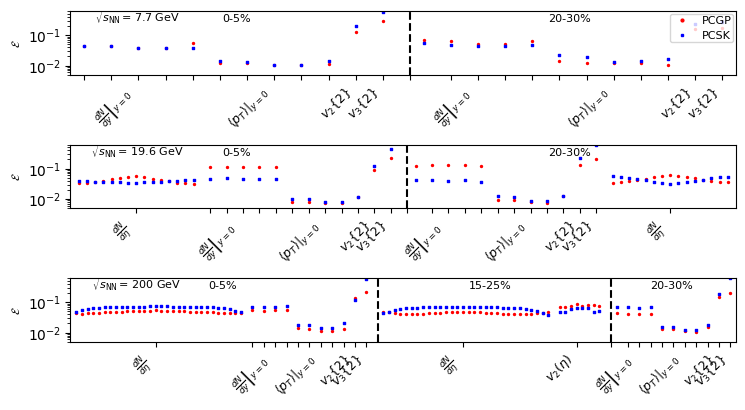

[INFO][_mathtext] Substituting symbol H from STIXNonUnicode


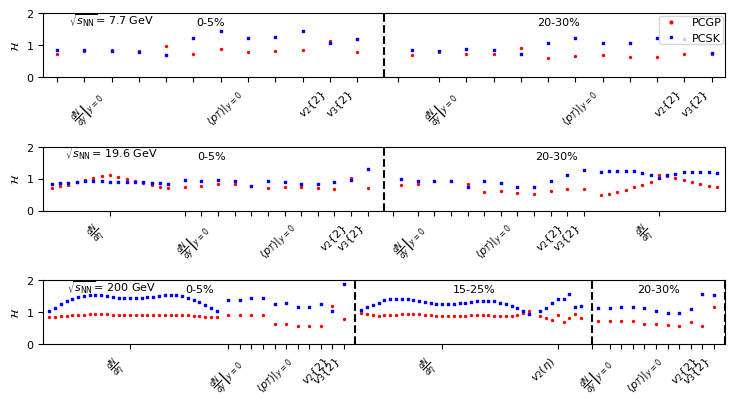

[INFO][_mathtext] Substituting symbol B from STIXNonUnicode


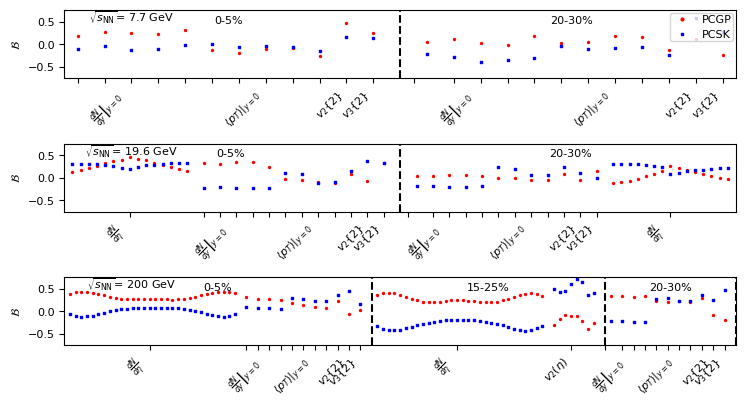

In [14]:
colors = ['r', 'b', 'g', 'magenta', 'teal', 'orange', 'purple', 'grey', 'seagreen']
cent_dict={'05':'0-5%','1525':'15-25%','2030':'20-30%'}
fig, axs = plt.subplots(3, 1, figsize=(7.5, 7.5/1.818))
plt.rc('font', size=8)

energies = ['7.7', '19.6', '200']
centralities = ['05', '1525', '2030']
id_max=[-1]
for i, energy in enumerate(energies):
    #axs[i].set_title(r'$\sqrt{s_{\mathrm{NN}}}$= ' +f'{energy} GeV')
    axs[i].text(0.1,0.77,'$\sqrt{s_{\mathrm{NN}}}$= ' +f'{energy} GeV', rotation=0, verticalalignment='bottom', horizontalalignment='center',transform=axs[i].transAxes)
    dataset_boundaries = [0]
    cent_boundaries = [0]
    idx_observable = 0
    midpoint=[]
    cent=[]
    for centrality in centralities:
        
        if centrality in data[energy]:
            cent_boundaries.append(idx_observable)
            for dataset in range(len(data[energy][centrality]["name"])):
                #idx = filename_prefix_list.index(f'exp_{energy}_{centrality}_{data[energy][centrality][dataset]}')
                # if(energy=='200'):
                #     print(data[energy][centrality][dataset])
                #     print(len(err1_list[dataset][-1]))
                #     print("-----")
                #print(data[energy][centrality]["name"][dataset])
                for obs in range(len(data[energy][centrality]["err1"][dataset])):
                    axs[i].scatter(idx_observable, np.abs(data[energy][centrality]["err1"][dataset][obs]), color=colors[0], marker='o', s=2)
                    axs[i].scatter(idx_observable, np.abs(data[energy][centrality]["err2"][dataset][obs]), color=colors[1], marker='s', s=2)
                    idx_observable += 1
                    #print(obs)
                    #print(dataset)
                    #print(energy,centrality,data[energy][centrality]["name"][dataset],idx_observable)
                    #print(data[energy][centrality][dataset])
                    
                idx_observable+=1
                dataset_boundaries.append(idx_observable)
                #print(energy,centrality,idx_observable)
            
            
            #if not (energy=='7.7' and centrality=='05'):
            
            #idx_observable+=2
            if not (energy in ['7.7','19.6'] and centrality=='1525'):
                axs[i].axvline(x=idx_observable, color='k', linestyle='--', zorder=(-10))
            idx_observable+=1
            if not (energy in ['7.7','19.6'] and centrality=='1525'):
                midpoint.append((idx_observable + cent_boundaries[-1]) / 2)
                cent.append(centrality)
            
    id_max.append(idx_observable)
    for k,mid in enumerate(midpoint):
        axs[i].text(mid/idx_observable, 0.8, cent_dict[cent[k]], rotation=0, verticalalignment='bottom', horizontalalignment='center',transform=axs[i].transAxes)
        
    
    average_indices = [(start + end) // 2  - 1 for start, end in zip(dataset_boundaries[:-1], dataset_boundaries[1:])]
    #print(dataset_boundaries)
    #print(average_indices)
    #print(labels)
    #print(average_indices)
    #print(average_indices)
    axs[i].set_xticks(average_indices)
    labels = [convert_to_notation(f'{obs}') for centrality in centralities for obs in data[energy][centrality]["name"]]
    #print(labels)
    #print(labels)
    #print(labels)
    axs[i].set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
    
    #for boundary, cent in zip(dataset_boundaries[:-1], centralities):
        

legend_elements = [
    plt.Line2D([0], [0], marker='o', color=colors[0], markersize=2, label='PCGP', linestyle='None'),
    plt.Line2D([0], [0], marker='s', color=colors[1], markersize=2, label='PCSK', linestyle='None'),
]

axs[0].legend(handles=legend_elements, loc='upper right', borderpad=0.12, borderaxespad=0.25)

for i,ax in enumerate(axs):
    ax.set_xlim([-1, id_max[i+1] - 2])
    ax.set_ylim([5e-3, 0.6])
    ax.set_ylabel(r"$\mathcal{E}$", fontsize=8)
    ax.set_yscale('log')
    #ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
    #ax.yaxis.set_major_locator(ticker.LogLocator(subs=[1.0, 2.0, 5.0]))  # Ensure at least two labels

plt.tight_layout()
#plt.savefig("err_full_training_set_LHCpoints_noPCA_LOG.pdf")


# # honesty plot
fig, axs = plt.subplots(3, 1, figsize=(7.5, 7.5/1.818))
plt.rc('font', size=8)

energies = ['7.7', '19.6', '200']
centralities = ['05', '1525', '2030']

for i, energy in enumerate(energies):
    #axs[i].set_title(r'$\sqrt{s_{\mathrm{NN}}}$= ' +f'{energy} GeV')
    axs[i].text(0.1,0.77,'$\sqrt{s_{\mathrm{NN}}}$= ' +f'{energy} GeV', rotation=0, verticalalignment='bottom', horizontalalignment='center',transform=axs[i].transAxes)

    dataset_boundaries = [0]
    cent_boundaries = [0]
    idx_observable = 0
    midpoint=[]
    cent=[]
    for centrality in centralities:
        
        if centrality in data[energy]:
            cent_boundaries.append(idx_observable)
            for dataset in range(len(data[energy][centrality]["name"])):
                #idx = filename_prefix_list.index(f'exp_{energy}_{centrality}_{data[energy][centrality][dataset]}')
                # if(energy=='200'):
                #     print(data[energy][centrality][dataset])
                #     print(len(err1_list[dataset][-1]))
                #     print("-----")
                #print(data[energy][centrality]["name"][dataset])
                for obs in range(len(data[energy][centrality]["err1"][dataset])):
                    axs[i].scatter(idx_observable, np.abs(data[energy][centrality]["hon1"][dataset][obs]), color=colors[0], marker='o', s=2)
                    axs[i].scatter(idx_observable, np.abs(data[energy][centrality]["hon2"][dataset][obs]), color=colors[1], marker='s', s=2)
                    idx_observable += 1
                    #print(obs)
                    #print(dataset)
                    #print(data[energy][centrality][dataset])
                    
                idx_observable+=1
                dataset_boundaries.append(idx_observable)
            
            if not (energy in ['7.7','19.6'] and centrality=='1525'):
                axs[i].axvline(x=idx_observable, color='k', linestyle='--', zorder=(-10))
            idx_observable+=1
            if not (energy in ['7.7','19.6'] and centrality=='1525'):
                midpoint.append((idx_observable + cent_boundaries[-1]) / 2)
                cent.append(centrality)
            
    id_max.append(idx_observable)
    for k,mid in enumerate(midpoint):
        axs[i].text(mid/idx_observable, 0.78, cent_dict[cent[k]], rotation=0, verticalalignment='bottom', horizontalalignment='center',transform=axs[i].transAxes)
    
    average_indices = [(start + end) // 2  - 1 for start, end in zip(dataset_boundaries[:-1], dataset_boundaries[1:])]
    #print(average_indices)
    #print(average_indices)
    axs[i].set_xticks(average_indices)
    labels = [convert_to_notation(f'{obs}') for centrality in centralities for obs in data[energy][centrality]["name"]]
    #print(labels)
    #print(labels)
    #print(labels)
    axs[i].set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
    axs[i].set_ylim([0, 2])
     
    #for boundary, cent in zip(dataset_boundaries[:-1], centralities):
        

legend_elements = [
    plt.Line2D([0], [0], marker='o', color=colors[0], markersize=2, label='PCGP', linestyle='None'),
    plt.Line2D([0], [0], marker='s', color=colors[1], markersize=2, label='PCSK', linestyle='None'),
]

axs[0].legend(handles=legend_elements, loc='upper right', borderpad=0.12, borderaxespad=0.25)

for i,ax in enumerate(axs):
    ax.set_xlim([-1, id_max[i+1]-1] )
    #ax.set_ylim([0, 1]) 
    ax.set_ylabel(r"$\mathcal{H}$", fontsize=8)
    #ax.set_yscale('log')
    #ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
    #ax.yaxis.set_major_locator(ticker.LogLocator(subs=[1.0, 2.0, 5.0]))  # Ensure at least two labels

plt.tight_layout()
#plt.savefig("hon_full_training_set_LHCpoints_noPCA_noLOG.pdf")


# # honesty plot
fig, axs = plt.subplots(3, 1, figsize=(7.5, 7.5/1.818))
plt.rc('font', size=8)

energies = ['7.7', '19.6', '200']
centralities = ['05', '1525', '2030']

for i, energy in enumerate(energies):
    #axs[i].set_title(r'$\sqrt{s_{\mathrm{NN}}}$= ' +f'{energy} GeV')
    axs[i].text(0.1,0.77,'$\sqrt{s_{\mathrm{NN}}}$= ' +f'{energy} GeV', rotation=0, verticalalignment='bottom', horizontalalignment='center',transform=axs[i].transAxes)

    dataset_boundaries = [0]
    cent_boundaries = [0]
    idx_observable = 0
    midpoint=[]
    cent=[]
    for centrality in centralities:
        
        if centrality in data[energy]:
            cent_boundaries.append(idx_observable)
            for dataset in range(len(data[energy][centrality]["name"])):
                #idx = filename_prefix_list.index(f'exp_{energy}_{centrality}_{data[energy][centrality][dataset]}')
                # if(energy=='200'):
                #     print(data[energy][centrality][dataset])
                #     print(len(err1_list[dataset][-1]))
                #     print("-----")
                #print(data[energy][centrality]["name"][dataset])
                for obs in range(len(data[energy][centrality]["err1"][dataset])):
                    axs[i].scatter(idx_observable, data[energy][centrality]["bias1"][dataset][obs], color=colors[0], marker='o', s=2)
                    axs[i].scatter(idx_observable, data[energy][centrality]["bias2"][dataset][obs], color=colors[1], marker='s', s=2)
                    idx_observable += 1
                    #print(obs)
                    #print(dataset)
                    #print(data[energy][centrality][dataset])
                    
                idx_observable+=1
                dataset_boundaries.append(idx_observable)
            
            if not (energy in ['7.7','19.6'] and centrality=='1525'):
                axs[i].axvline(x=idx_observable, color='k', linestyle='--', zorder=(-10))
            idx_observable+=1
            if not (energy in ['7.7','19.6'] and centrality=='1525'):
                midpoint.append((idx_observable + cent_boundaries[-1]) / 2)
                cent.append(centrality)
            
    id_max.append(idx_observable)
    for k,mid in enumerate(midpoint):
        axs[i].text(mid/idx_observable, 0.78, cent_dict[cent[k]], rotation=0, verticalalignment='bottom', horizontalalignment='center',transform=axs[i].transAxes)
    
    average_indices = [(start + end) // 2  - 1 for start, end in zip(dataset_boundaries[:-1], dataset_boundaries[1:])]
    #print(average_indices)
    #print(average_indices)
    axs[i].set_xticks(average_indices)
    labels = [convert_to_notation(f'{obs}') for centrality in centralities for obs in data[energy][centrality]["name"]]
    #print(labels)
    #print(labels)
    #print(labels)
    axs[i].set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
    axs[i].set_ylim([-0.75, 0.75])
     
    #for boundary, cent in zip(dataset_boundaries[:-1], centralities):
        

legend_elements = [
    plt.Line2D([0], [0], marker='o', color=colors[0], markersize=2, label='PCGP', linestyle='None'),
    plt.Line2D([0], [0], marker='s', color=colors[1], markersize=2, label='PCSK', linestyle='None'),
]

axs[0].legend(handles=legend_elements, loc='upper right', borderpad=0.12, borderaxespad=0.25)

for i,ax in enumerate(axs):
    ax.set_xlim([-1, id_max[i+1]-1] )
    #ax.set_ylim([0, 1]) 
    ax.set_ylabel(r"$\mathcal{B}$", fontsize=8)
    ax.set_yscale('linear')
    #ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
    #ax.yaxis.set_major_locator(ticker.LogLocator(subs=[1.0, 2.0, 5.0]))  # Ensure at least two labels

plt.tight_layout()
plt.savefig("bias_full_training_set_LHCpoints_noPCA_noLOG.pdf")

def write_data_to_csv(data, filename):
    with open(filename, 'w', newline='') as csvfile:
        fieldnames = ['Energy', 'Centrality', 'Observable', 'Error PCGP', 'Error PCSK', 'Honesty PCGP', 'Honesty PCSK', 'Bias PCGP', 'Bias PCSK']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        
        writer.writeheader()
        for energy in data:
            for centrality in data[energy]:
                for i, observable in enumerate(data[energy][centrality]["name"]):
                    writer.writerow({
                        'Energy': energy,
                        'Centrality': centrality,
                        'Observable': observable,
                        'Error PCGP': data[energy][centrality]["err1"][i],
                        'Error PCSK': data[energy][centrality]["err2"][i],
                        'Honesty PCGP': data[energy][centrality]["hon1"][i],
                        'Honesty PCSK': data[energy][centrality]["hon2"][i],
                        'Bias PCGP': data[energy][centrality]["bias1"][i],
                        'Bias PCSK': data[energy][centrality]["bias2"][i]
                    })

# Write the data to CSV
write_data_to_csv(data, 'emulator_validation_data.csv')